In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

In [3]:
# Import data as data frames

red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
white_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep = ';')
white_wine.Name = 'white wine'
red_wine.Name = 'red wine'

In [4]:
red_wine['type'] = 'red'
white_wine['type'] = 'white'

In [8]:
# Select white wines with a quality of 5, 6 or 7
white_wine_567 = white_wine[(white_wine['quality'] == 5) | (white_wine['quality'] == 6) | (white_wine['quality'] == 7)]

In [9]:
white_wine_567['quality'].value_counts()

6    2198
5    1457
7     880
Name: quality, dtype: int64

In [11]:
features = list (white_wine_567.columns)
features.remove('quality')
features.remove('type')
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

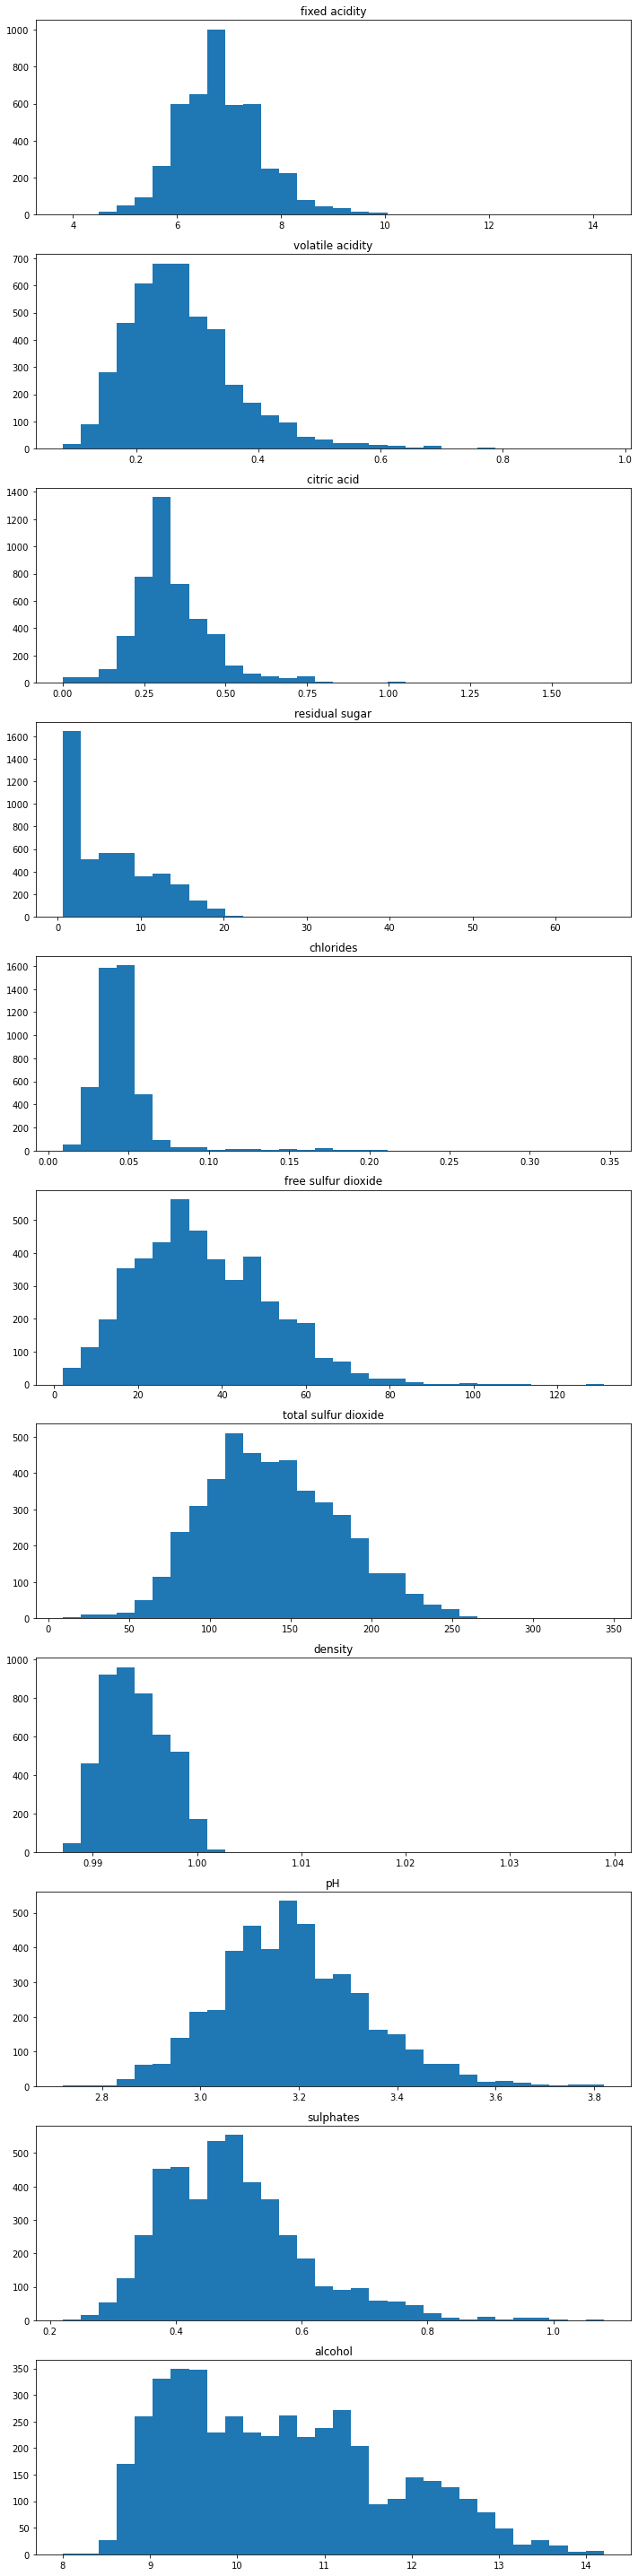

In [13]:
# Look at distribution of features

fig, ax = plt.subplots(len(features), 1, figsize = (10, 40))

for i, feature in enumerate (features):
    ax[i].hist(white_wine_567[feature], bins = 30)
    ax[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

Residual sugar and alcohol look non-Gaussian. <br> But overall, features look more Gaussian than when we looked at all white wines together.

Try some transformations

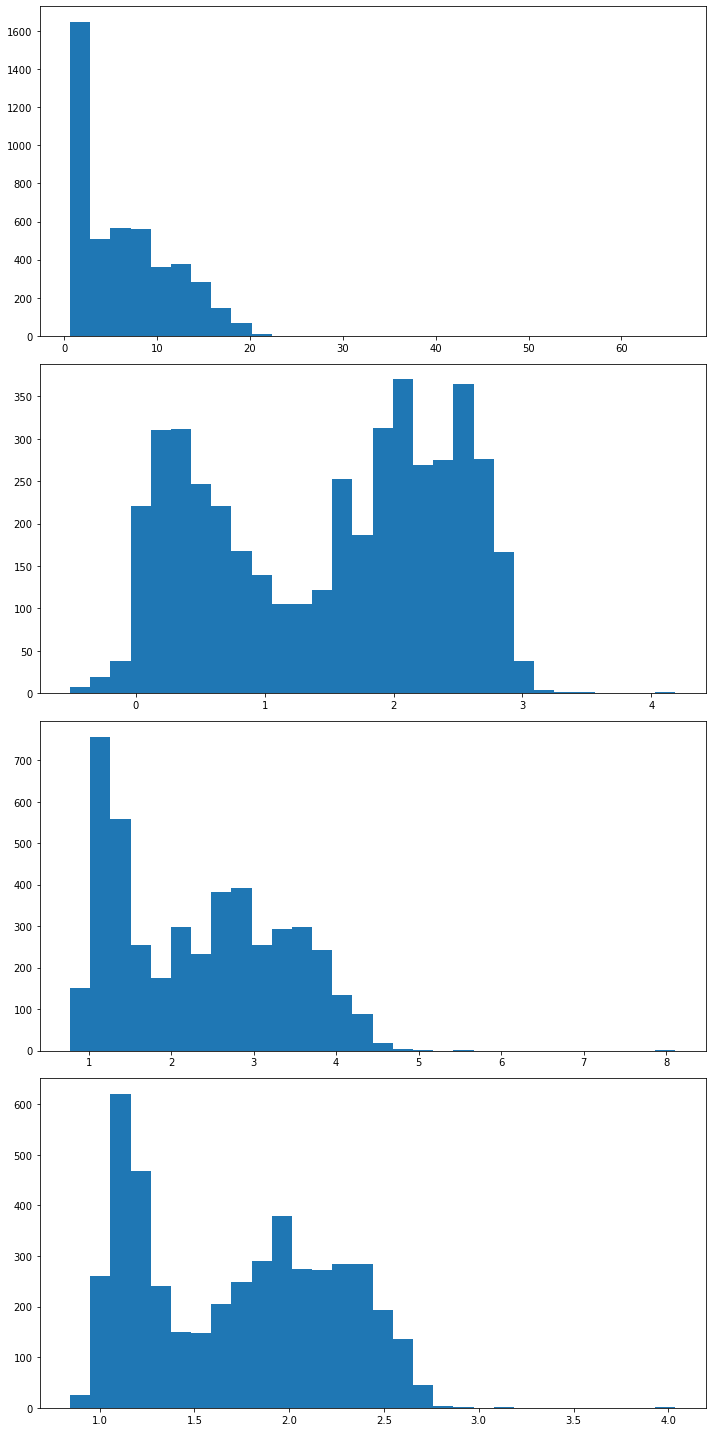

In [14]:

white_res_sug = white_wine_567['residual sugar'].to_numpy()

t1 = np.log(white_res_sug)              # t1 = log(x)
t2 = np.sqrt(white_res_sug)            # t2 = sqrt(x)

power_degree = [(1/3) for i in range (len(white_res_sug))]

t3 = np.power(white_res_sug, power_degree)  # t3 = x ^ (1/3)

fig, ax = plt.subplots(4,1, figsize = ( 10, 20))
ax[0].hist(white_res_sug, bins = 30)          # Plot original
ax[1].hist(t1, bins = 30)                           # Plot t1
ax[2].hist(t2, bins = 30)                           # Plot t2
ax[3].hist(t3, bins = 30)                           # Plot t2

plt.tight_layout()
plt.show()

In [15]:
pd.DataFrame(white_res_sug).skew(), pd.DataFrame(white_res_sug).kurt()

(0    1.072693
 dtype: float64,
 0    3.576237
 dtype: float64)

In [16]:
pd.DataFrame(t1).skew(), pd.DataFrame(t1).kurt()

(0   -0.179624
 dtype: float64,
 0   -1.35065
 dtype: float64)

In [17]:
pd.DataFrame(t2).skew(), pd.DataFrame(t2).kurt()

(0    0.298235
 dtype: float64,
 0   -0.944545
 dtype: float64)

In [18]:
pd.DataFrame(t3).skew(), pd.DataFrame(t3).kurt()

(0    0.124739
 dtype: float64,
 0   -1.209211
 dtype: float64)

The t2 transformation (sqrt(x)) seems best

<h5> Alcohol transformation </h5>

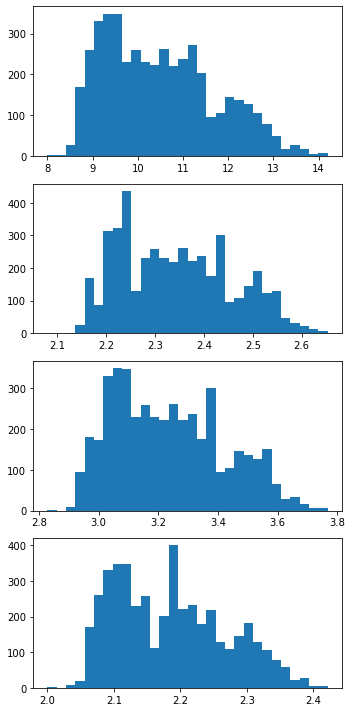

In [20]:

white_alcohol = white_wine_567['alcohol'].to_numpy()

t1 = np.log(white_alcohol)              # t1 = log(x)
t2 = np.sqrt(white_alcohol)            # t2 = sqrt(x)

power_degree = [(1/3) for i in range (len(white_alcohol))]

t3 = np.power(white_alcohol, power_degree)  # t3 = x ^ (1/3)

fig, ax = plt.subplots(4,1, figsize = ( 5, 10))
ax[0].hist(white_alcohol, bins = 30)          # Plot original
ax[1].hist(t1, bins = 30)                           # Plot t1
ax[2].hist(t2, bins = 30)                           # Plot t2
ax[3].hist(t3, bins = 30)                           # Plot t2

plt.tight_layout()
plt.show()

In [21]:
pd.DataFrame(white_alcohol).skew(), pd.DataFrame(white_alcohol).kurt()

(0    0.523787
 dtype: float64,
 0   -0.629479
 dtype: float64)

In [22]:
pd.DataFrame(t1).skew(), pd.DataFrame(t1).kurt()

(0    0.344467
 dtype: float64,
 0   -0.851887
 dtype: float64)

In [23]:
pd.DataFrame(t2).skew(), pd.DataFrame(t2).kurt()

(0    0.433112
 dtype: float64,
 0   -0.752744
 dtype: float64)

In [24]:
pd.DataFrame(t3).skew(), pd.DataFrame(t3).kurt()

(0    0.403343
 dtype: float64,
 0   -0.78839
 dtype: float64)

Eh. None of them are really a meaningful improvement. Keep alcohol feature as is.

In [25]:
white_wine_567['residual sugar norm'] = np.sqrt(white_wine_567['residual sugar'])

/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_7764/3499086969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_wine_567['residual sugar norm'] = np.sqrt(white_wine_567['residual sugar'])


In [26]:
white_wine_567.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,residual sugar norm
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,4.549725
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,1.264911
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,2.626785
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,2.915476
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,2.915476


In [27]:
X = white_wine_567 [['fixed acidity', 'volatile acidity', 'citric acid', 
                'residual sugar norm', 'chlorides', 'free sulfur dioxide',
                'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]

In [28]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar norm,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,4.549725,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.264911,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,2.626785,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,2.915476,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,2.915476,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [29]:
y = white_wine_567['quality']

In [30]:
# Train | Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# Scale
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [31]:
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix


In [32]:
log_model.fit(scaled_X_train, y_train)
y_pred = log_model.predict(scaled_X_test)
accuracy_score(y_test,y_pred)

0.5846560846560847

Hum. OK. Only a tiny mild improvement.

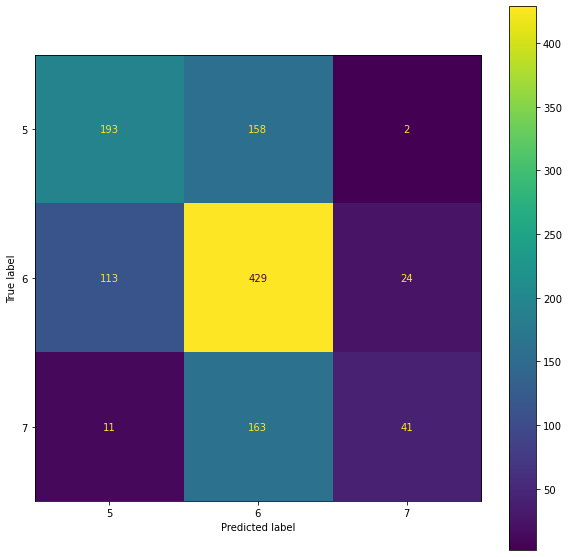

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(log_model,scaled_X_test,y_test, ax = ax)

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           5       0.61      0.55      0.58       353
           6       0.57      0.76      0.65       566
           7       0.61      0.19      0.29       215

    accuracy                           0.58      1134
   macro avg       0.60      0.50      0.51      1134
weighted avg       0.59      0.58      0.56      1134



The worst metric is the recall for quality = 7. The others are at least over 50%

<h3> GridSearch for Best Hyper Parameters </h3>

In [35]:
# Create base log reg model
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)

penalty = ['l1', 'l2']
#C = [1000, 100, 10, 1, 0.1, 0.01, 0.001] 

# Documentation  recommends logarithmic spacing. So afterwards try C = np.logspace(0, 1000, 10)

C = np.logspace(0,100,10)

grid_model = GridSearchCV(log_model,param_grid={'C':C,'penalty':penalty})

In [36]:
grid_model.fit(scaled_X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e+000, 1.29154967e+011, 1.66810054e+022, 2.15443469e+033,
       2.78255940e+044, 3.59381366e+055, 4.64158883e+066, 5.99484250e+077,
       7.74263683e+088, 1.00000000e+100]),
                         'penalty': ['l1', 'l2']})

In [37]:
grid_model.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [43]:
# Create base log reg model
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)

penalty = ['l1', 'l2']
#C = [1000, 100, 10, 1, 0.1, 0.01, 0.001] 

# Documentation  recommends logarithmic spacing. So afterwards try C = np.logspace(0, 1000, 10)

C = np.logspace(0.1,10,10)

grid_model = GridSearchCV(log_model,param_grid={'C':C,'penalty':penalty})

In [45]:
grid_model.fit(scaled_X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.25892541e+00, 1.58489319e+01, 1.99526231e+02, 2.51188643e+03,
       3.16227766e+04, 3.98107171e+05, 5.01187234e+06, 6.30957344e+07,
       7.94328235e+08, 1.00000000e+10]),
                         'penalty': ['l1', 'l2']})

In [46]:
grid_model.best_params_

{'C': 1.2589254117941673, 'penalty': 'l1'}

<h3> Predict and Evaluate </h3>

In [48]:
y_pred = grid_model.predict(scaled_X_test)

In [49]:
accuracy_score(y_test,y_pred)

0.5873015873015873

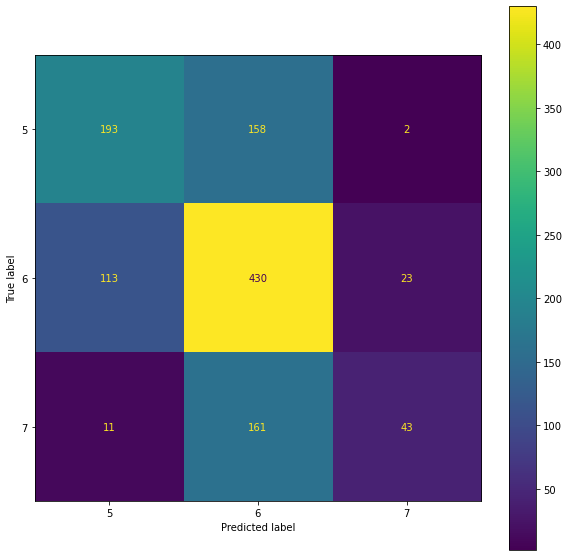

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(grid_model,scaled_X_test,y_test, ax = ax)

In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           5       0.61      0.55      0.58       353
           6       0.57      0.76      0.65       566
           7       0.63      0.20      0.30       215

    accuracy                           0.59      1134
   macro avg       0.61      0.50      0.51      1134
weighted avg       0.60      0.59      0.56      1134



Even after hyperparameter tuning, scores don't improve.

So we've tried two things: <br>
1. Create 5 classes: (0-4), 5, 6, 7, (8-10)
2. Create just 3 classes: 5, 6, 7
In the second case, the accuracy barely improved.

The precision and recall for quality 5,6,7 did marginally improve. But not nearly as much as we'd hoped.